# Viva Streets Impact by Neighborhood

Is there a reduction in crashes around Viva Streets on Sundays? Look for crashes in the vicinity compared to the city as a whole. 

Viva Streets closures:

* Broadway from Alameda north
* Continues up Welton
* Ends at Downing

In [1]:
import json
import pytz
import folium
from folium.features import DivIcon
from folium.plugins import HeatMap

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib._color_data import TABLEAU_COLORS

import os
os.chdir('..')

from scripts.crash_data_analysis import CrashDataAnalysis

In [2]:
cda = CrashDataAnalysis()

## Neighborhood Analysis

Did the neighborhoods around Viva Streets see changes in the number of crashes? 

In [3]:
# neighborhoods bordering viva streets

# ['Washington Park West'
# , 'Speer'
# , 'Capitol Hill'
# , 'North Capitol Hill'
# , 'Civic Center'
# , 'CBD'
# , 'Five Points'
# , 'Baker'
# , 'Lincoln Park']

In [4]:
# # All neighborhoods
# query = """
# select
# to_char(reported_date at time zone 'America/Denver', 'YYYY-MM-DD') as crash_date
# , to_char(reported_date at time zone 'America/Denver', 'Mon FMDD, YYYY') as crash_date_str
# , count(*) as num_crashes

# from crashes c

# where extract(isodow from reported_date at time zone 'America/Denver') = 7
# and date_part('year', reported_date) = 2023

# group by 1,2
# order by 1
# """

# sunday_crashes = pd.read_sql(query, cda.conn)
# sunday_crashes

In [5]:
# Split by neighborhood

query = """
    with crash_hoods as (
    select 
    c.reported_date
    , sn.nbhd_name
    , sn.nbhd_name in ('Washington Park West'
    , 'Speer', 'Capitol Hill', 'North Capitol Hill'
    , 'Civic Center', 'CBD', 'Five Points', 'Baker') as viva_neighborhood

    from crashes c, statistical_neighborhoods sn
    where ST_Contains(sn.geom_denver, c.geom_denver)
)

select
to_char(reported_date at time zone 'America/Denver', 'YYYY-MM-DD') as crash_date
, to_char(reported_date at time zone 'America/Denver', 'Mon FMDD') as crash_date_str
, count(*) as num_crashes
, sum(viva_neighborhood::int) as num_crashes_in_viva_neighborhood
, sum((not viva_neighborhood)::int) as num_crashes_not_in_viva_neighborhood

from crash_hoods ch

where extract(isodow from reported_date at time zone 'America/Denver') = 7
and date_part('year', reported_date) = 2023

group by 1,2
order by 1"""

sunday_crashes = pd.read_sql(query, cda.conn)

In [6]:
assert ((
    sunday_crashes.num_crashes 
    == sunday_crashes.num_crashes_in_viva_neighborhood + sunday_crashes.num_crashes_not_in_viva_neighborhood
).all()), 'Sum of crashes should match total'

In [7]:
sunday_crashes['perc_in_viva_neighborhoods'] = (
    sunday_crashes.num_crashes_in_viva_neighborhood / sunday_crashes.num_crashes
)

In [8]:
# Color the Viva days orange

data_to_plot = sunday_crashes.copy()

viva_sundays = [
    datetime(2023, 5, 14)
    , datetime(2023, 6, 4)
    , datetime(2023, 7, 9)
    , datetime(2023, 8, 6)
]

data_to_plot['crash_date'] = pd.to_datetime(data_to_plot['crash_date'])

data_to_plot['color'] = 'lightgrey'
data_to_plot.loc[data_to_plot.crash_date.isin(viva_sundays), 'color'] = TABLEAU_COLORS['tab:orange']

data_to_plot['label'] = 'Not Viva Sunday'
data_to_plot.loc[data_to_plot.crash_date.isin(viva_sundays), 'label'] = 'Viva Sunday'

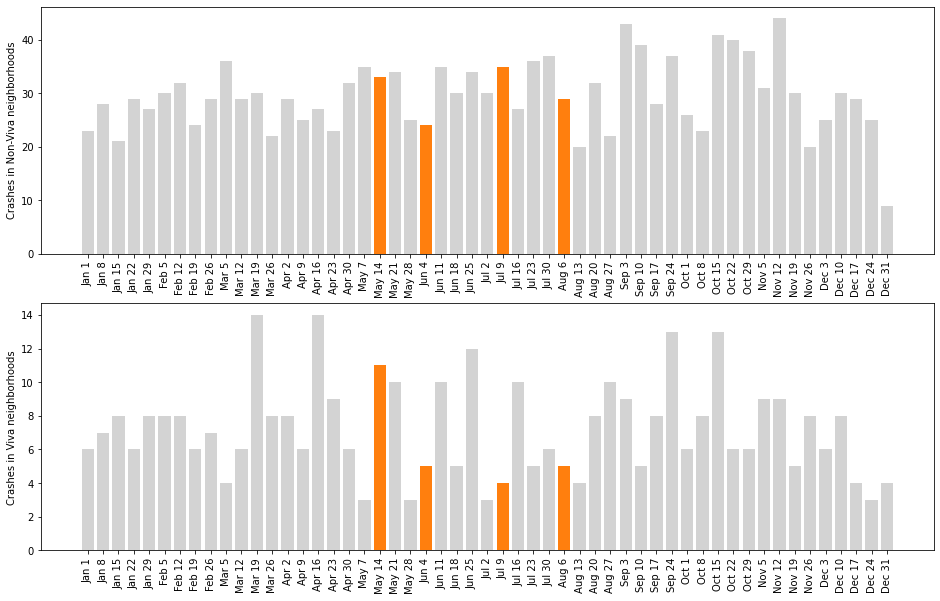

In [9]:
fig, ax = plt.subplots(figsize=(16,10), nrows=2, ncols=1)

ax[0].bar(
    x=data_to_plot.crash_date_str
    , height=data_to_plot.num_crashes_not_in_viva_neighborhood
    , color=data_to_plot.color
)

ax[0].tick_params(axis='x', rotation=90)
ax[0].set_ylabel('Crashes in Non-Viva neighborhoods')

ax[1].bar(
    x=data_to_plot.crash_date_str
    , height=data_to_plot.num_crashes_in_viva_neighborhood
    , color=data_to_plot.color
)

ax[1].tick_params(axis='x', rotation=90)
_ = ax[1].set_ylabel('Crashes in Viva neighborhoods')


# _ = plt.title('Crashes on Sundays')

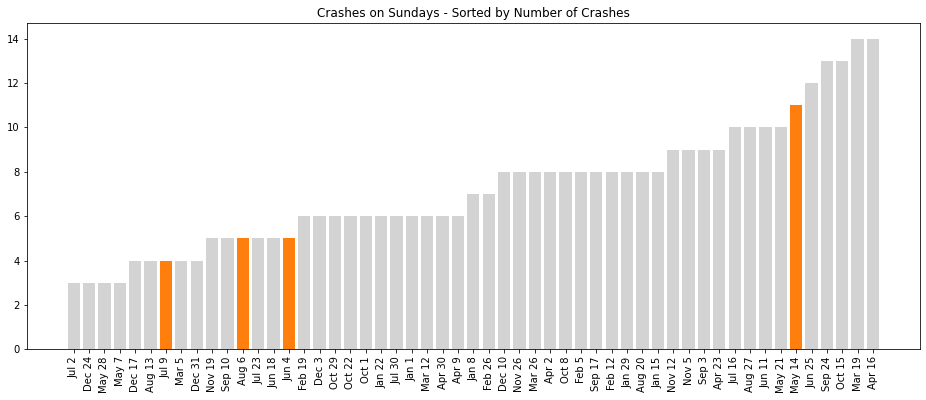

In [10]:
data_to_plot_sorted = data_to_plot.sort_values(by='num_crashes_in_viva_neighborhood')

fig, ax = plt.subplots(figsize=(16,6))

ax.bar(
    x=data_to_plot_sorted.crash_date_str
    , height=data_to_plot_sorted.num_crashes_in_viva_neighborhood
    , color=data_to_plot_sorted.color
)

ax.tick_params(axis='x', rotation=90)

_ = plt.title('Crashes on Sundays - Sorted by Number of Crashes')

In [11]:
data_to_plot.groupby('label').agg(
    num_crashes_in_viva=('num_crashes_in_viva_neighborhood', 'median')
    , num_crashes_not_in_viva=('num_crashes_not_in_viva_neighborhood', 'median')
    , num_days=('color', 'count')
)

,num_crashes_in_viva,num_crashes_not_in_viva,num_days
label,,,
Not Viva Sunday,7.0,29.0,49
Viva Sunday,5.0,31.0,4


In [12]:
data_to_plot[data_to_plot.label == 'Viva Sunday']

,crash_date,crash_date_str,num_crashes,num_crashes_in_viva_neighborhood,num_crashes_not_in_viva_neighborhood,perc_in_viva_neighborhoods,color,label
19,2023-05-14,May 14,44,11,33,0.250000,#ff7f0e,Viva Sunday
22,2023-06-04,Jun 4,29,5,24,0.172414,#ff7f0e,Viva Sunday
27,2023-07-09,Jul 9,39,4,35,0.102564,#ff7f0e,Viva Sunday
31,2023-08-06,Aug 6,34,5,29,0.147059,#ff7f0e,Viva Sunday


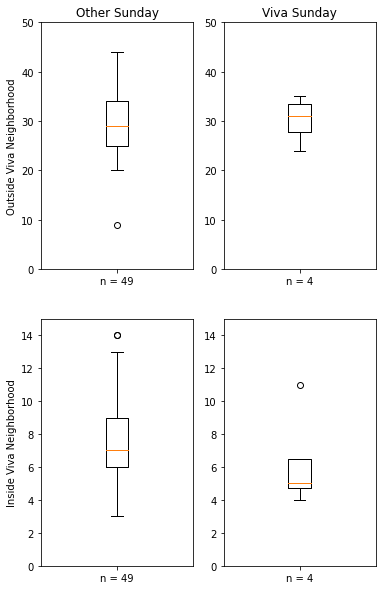

In [13]:
fig, ax = plt.subplots(figsize=(6,10), nrows=2, ncols=2)
ax[0][0].boxplot(data_to_plot.loc[data_to_plot.label == 'Not Viva Sunday', 'num_crashes_not_in_viva_neighborhood'])
ax[0][1].boxplot(data_to_plot.loc[data_to_plot.label == 'Viva Sunday', 'num_crashes_not_in_viva_neighborhood'])
ax[1][0].boxplot(data_to_plot.loc[data_to_plot.label == 'Not Viva Sunday', 'num_crashes_in_viva_neighborhood'])
ax[1][1].boxplot(data_to_plot.loc[data_to_plot.label == 'Viva Sunday', 'num_crashes_in_viva_neighborhood'])

ax[0][0].set_ylim([0,50])
ax[0][1].set_ylim([0,50])
ax[1][0].set_ylim([0,15])
ax[1][1].set_ylim([0,15])

ax[0][0].set_title('Other Sunday')
ax[0][1].set_title('Viva Sunday')
ax[0][0].set_ylabel('Outside Viva Neighborhood')
ax[1][0].set_ylabel('Inside Viva Neighborhood')

ax[0][0].set_xticklabels(['n = 49'])
ax[0][1].set_xticklabels(['n = 4'])
ax[1][0].set_xticklabels(['n = 49'])
ax[1][1].set_xticklabels(['n = 4'])

plt.savefig('images/viva_neighborhood_boxplot.png', transparent=False, facecolor='white', bbox_inches='tight')

_ = 'a'